# HDR gathering
Like basic gather, but with multiple pictures taken at different attenuations.

## Setup
Run `python f_camera_photonics\tcp_link.py` on the lab computer. Only one thing can use the analog port at a time, so make sure it is grabbing from the digital only.

In this notebook, run the first couple cells and make sure directories are set up. Check whether remote pictures are working. During the gathering process, you should turn off the lamp when taking pictures you want to use for data.

Picking ports can be done manually or semi-manually.

## Gathering
I've found it easier to defocus, but not too much. Too much then you miss weak spots. Not enough and peaks could fall between pixels

In [568]:
%load_ext autoreload
%autoreload 2
%matplotlib inline

import cv2
import sys, os
import numpy as np
import pickle
import matplotlib.pyplot as plt

sys.path.append('..')
# import f_camera_photonics
from f_camera_photonics.component_capture import single_shot
from f_camera_photonics import cvshow
from f_camera_photonics.peak_finder import f_camera_photonics, main, get_all_config, PortArray
from f_camera_photonics.tcp_link import remote_call, capture, attenuate, unpack_image

The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload


In [906]:
remote = True
datadir = '../measurement_data/chicken01-loopMirrors-chipA/'

sample_name = 'x3-y8'  # change this every device
def to_file(extension):
    return os.path.join(datadir, sample_name + extension)

In [907]:
def save_matrix(HDR, Powers):
    pickle.dump(Powers, open(to_file('.pickle'), 'wb'))
    
    metadata = dict(HDR_vals=list(HDR),
                    laser_Amps=0.130)  # this second row you fill out manually
    pickle.dump(metadata, open(to_file('.metadata.pickle'), 'wb'))
    
    fi, ax = plt.subplots(figsize=(10, 5))
    ax.loglog(10 ** (-HDR / 10), Powers, '.-')
    ax.grid(which='minor')
    plt.xlabel('Attenuation')
    plt.ylabel('Port power')
    plt.title(sample_name)
    plt.savefig(to_file('.png'))

## Preview valid box
You will be given a preview of the valid box. Make sure your spots are within it. You can turn on/off this option in `config.ini`: `use_valid_box`.

You can do this with the lamp on to adjust, but make sure to turn it off the last time you run this cell.

In [908]:
if remote:
    remote_call(attenuate, atten=10)
    img = unpack_image(remote_call(capture, avgcnt=2))
else:
    atten_db(atten=10)
    img = single_shot()
    
cfg=get_all_config()
if cfg.valid_box is not None:
    x, y, w, h = cfg.valid_box
#     cv2.rectangle(img, (x, y), (x+w, y+h), (0,0,255), 2)
    
cv2.imwrite(to_file('.tif'), img)
# cv2.imwrite(os.path.join(datadir, 'typical-00dB-bright.tif'), img)  # various pictures you want to save otherwise

# cvshow(img)

/Users/ant12/Documents/git-projects/experiment-code/camera_photonics/f_camera_photonics/config.ini


True

### If you are satisfied with the valid box, turn out the lamp and move on

## Find the port box spec on the saved image
You will be given a preview of the port boxes in green. Make sure they hit your ports. There are two options for selecting the ports

#### Automatic
This uses the peakfinder algorithm. It is recommended you use this only with the valid box option turned on. The number of ports is specified in `config.ini`. You can override the config in the arguments.

This can be a little finicky. The ports must be detectable at a single intensity level. You have to make the `box_width` big enough so it doesn't think there are two peaks within one peak.

Used for
- chicken WG cutbacks

#### Manual
This can be easier when some ports are not visible or when there's a regular spacing of ports from experiment-to-experiment. You just have to guess and check this one.

Used for
- chicken loop mirror characterization
- sheep02 absorption trees and HiDRAs

In [909]:
# No file artifacts
# pout = f_camera_photonics(filename=tif_file, box_spec=None, max_box_width=10)
# port_arr = PortArray.from_dict(pout)

if True:  # Use the manual box spec or not
    # This is set up so you put the center spot right next to the line of dead pixels
    all_y = 251
#     xlist = np.linspace(27, 449, 16)
    xlist = [303, 325, 347]
    my_boxspec = [[x, all_y, 10] for x in xlist]
else:
    my_boxspec = None


# File artifacts
main(filename=to_file('.tif'), box_spec=my_boxspec, box_width=10)
with open(to_file('.json'), 'r') as fx:
    port_arr = PortArray.from_dict(json.load(fx))
port_arr.sort_by('position')
    
print(port_arr)

/Users/ant12/Documents/git-projects/experiment-code/camera_photonics/f_camera_photonics/config.ini
The maximum value in the image after darkfield correction is: 246.0 (out of a camera limit of 4095.0)
(#1, P: 1.00)
(#2, P: 0.49)
(#3, P: 0.00)
Check if it is correct
Press any key to close the display window


/Users/ant12/Documents/git-projects/experiment-code/camera_photonics/f_camera_photonics/peak_finder.py:356: RuntimeWarning: divide by zero encountered in log10
  img_8bit = np.log10(img_8bit)


Saving to x3-y8.json in ../measurement_data/chicken01-loopMirrors-chipA
[array([3.0300e+02, 2.5100e+02, 1.0000e+01, 9.0516e+04]), array([3.2500e+02, 2.5100e+02, 1.0000e+01, 4.3956e+04]), array([347., 251.,  10.,  33.])]


### If you are satisfied with port boxes, move on

## HDR image taking

In [910]:
HDR_vals = np.linspace(0, 36, 30)
P_matrix = np.ones((len(HDR_vals), len(port_arr)))
for i, db in enumerate(HDR_vals):
    if remote:
        remote_call(attenuate, atten=db)
        img = unpack_image(remote_call(capture, avgcnt=3))
    else:
        atten_db(db)
        img = single_shot()
    print('i =', i)
    P_matrix[i, :] = port_arr.calc_powers(img, use_max=True)
remote_call(attenuate, atten=7)  # reset

i = 0
i = 1
i = 2
i = 3
i = 4
i = 5
i = 6
i = 7
i = 8
i = 9
i = 10
i = 11
i = 12
i = 13
i = 14
i = 15
i = 16
i = 17
i = 18
i = 19
i = 20
i = 21
i = 22
i = 23
i = 24
i = 25
i = 26
i = 27
i = 28
i = 29


7

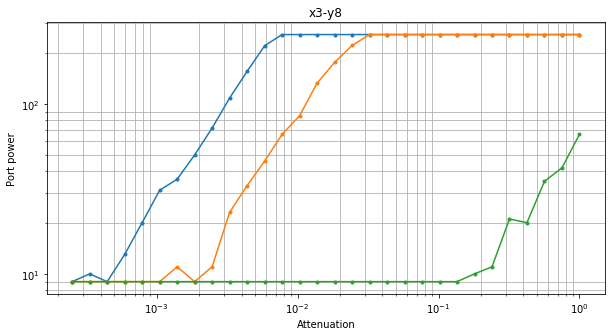

In [911]:
# if you like it save it
save_matrix(HDR_vals, P_matrix)

In [ ]:
plt.loglog(10 ** (-HDR_vals / 10), P_matrix[:, ::2]-np.min(P_matrix)+1e2, '.-')